# Refine labels for CD8aa, DN T, gdT, and MAIT cells

In this notebook, we load all CD8aa, DN T, gdT, and MAIT cells across our subjects to refine final L3 labels. We'll combine, recluster, and assign final labels by taking the most frequent AIFI_L3 label in each cluster, and back-propogate those L3 labels to L2 and L1 based on our cell type hierarcy.

We'll also generate metadata, UMAP coordinates, and marker gene summaries for review of our final labels, then store all of the outputs in HISE for later use.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
class_name = 'cd8aa_dnt_gdt_mait'

## Helper functions

These functions make it easy to utilize files from the HISE cache

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

This function uses the most frequent label within each cluster to refine label assignments.

In [29]:
def single_value(series):
    res = []
    for value in series:
        if isinstance(value, pd.core.arrays.categorical.Categorical) or isinstance(value, list):
            res.append(value[0])
        else:
            res.append(value)
    return res

In [8]:
def assign_most_frequent(adata, clusters, labels, keep_original = False, original_prefix = 'predicted_'):
    obs = adata.obs
    
    most_frequent_labels = (
        adata.obs
        .groupby(clusters)[labels]
        .agg(pd.Series.mode)
        .to_frame()
        .reset_index()
    )
    most_frequent_labels[labels] = single_value(most_frequent_labels[labels])
    
    if keep_original:
        obs = obs.rename({labels: original_prefix + labels}, axis = 1)
    else:
        obs = obs.drop(labels, axis = 1)
    
    obs = obs.merge(most_frequent_labels, on = clusters, how = 'left')
    
    adata.obs = obs
    
    return adata

This function back-propagates hierarchical labeling from AIFI_L3 back to AIFI_L2 and AIFI_L1 to ensure our labels agree across levels of our cell type hierarchy.

In [9]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
    
    adata.obs = obs

    return adata

These functions are used to assemble marker gene expression tables for review

In [10]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def marker_mean_df(adata, markers, log = False, clusters = 'louvain_2'):
    gene_cl_mean = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True,
        log = log
    ).dot_color_df
    
    return gene_cl_mean

def tidy_marker_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, markers, clusters)
    gene_cl_frac = gene_cl_frac.reset_index(drop = False)
    gene_cl_frac = pd.melt(gene_cl_frac, id_vars = clusters, var_name = 'gene', value_name = 'gene_frac')
    
    gene_cl_mean = marker_mean_df(adata, markers, log = False, clusters = clusters)
    gene_cl_mean = gene_cl_mean.reset_index(drop = False)
    gene_cl_mean = pd.melt(gene_cl_mean, id_vars = clusters, var_name = 'gene', value_name = 'gene_mean')

    marker_df = gene_cl_frac.merge(gene_cl_mean, on = [clusters, 'gene'], how = 'left')
    return marker_df

In [11]:
def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_above_gene_mean(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_mean = marker_mean_df(adata, gene, log = True, clusters = clusters)
    select_cl = gene_cl_mean.index[gene_cl_mean[gene] > cutoff].tolist()

    return select_cl

This function applies data analysis methods to our scRNA-seq data, including normalization, HVG selection, PCA, nearest neighbors, UMAP, and Leiden clustering.

In [12]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')

    # print('Harmony', end = "; ")
    # # Integrate subjects
    # sce.pp.harmony_integrate(
    #     adata, 
    #     'subject.subjectGuid',
    #     max_iter_harmony = 30,
    #     verbose = False
    # )
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 15,
        n_pcs = 30,
        # use_rep = 'X_pca_harmony'
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 5
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

This function retrieves both observations and UMAP coordinates in a single table for review.

In [13]:
def obs_with_umap(adata):
    obs = adata.obs
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']

    return obs

In [14]:
def isg_hi_refinement(adata, clusters = 'leiden_2', refine_res = 2):
    isg_hi_cl = select_clusters_above_gene_frac(
        adata, 'IFI44L', 0.2, clusters = clusters
    )
    print(isg_hi_cl)
    
    isg_adata = adata[adata.obs[clusters].isin(isg_hi_cl)]
    
    isg_adata = process_adata(isg_adata, resolution = refine_res)
    isg_adata = assign_most_frequent(
        isg_adata, 
        'leiden_{r}'.format(r = refine_res), 'AIFI_L3',
        keep_original = True,
        original_prefix = 'predicted_'
    )

    isg_df = isg_adata.obs[['barcodes', 'AIFI_L3', 'predicted_AIFI_L3']]
    return isg_df

This function generates a quasi-random ID to make searching for outputs easier

In [15]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Read cell type hierarchy from HISE

As part of label refinement, we'll back-propagate our cell type labels from refined AIFI_L3 labels to their parent cell classes at AIFI_L2 and AIFI_L1. To do this, we need the hierarchical relationships between these levels, which have been generated for our cell type reference dataset.

In [16]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files in HISE

For this analysis, we'll read in these files from HISE storage from previous steps. We'll group these into "large" files, which are from the set of 5 very large cell type assignments, and "small" files, which are from other cell types.

In [17]:
h5ad_uuids = {
    'CD8aa': 'da603bcc-e5f3-4ede-889f-e055b60d054d',
    'DN-T-cell': '7c528158-b0c3-473a-9256-54bdaf510d66',
    'gdT': 'ec9f2e39-a65c-4e1a-b7e8-80b818d06166',
    'MAIT': '35912dbb-1911-45fb-8c20-5e3794b3961b'
}

## Read and assemble datasets

In [18]:
adata_dict = {}
for group_name, uuid in h5ad_uuids.items():
    adata_dict[group_name] = read_adata_uuid(uuid)

In [19]:
adata = sc.concat(adata_dict)

## Process data

Here, we'll process all of our cells together for clustering and review.

In [20]:
out_h5ad = out_file = 'output/diha_{c}_AIFI_L3_review_{d}.h5ad'.format(
    c = class_name,
    d = date.today()
)

In [21]:
adata = process_adata(adata, resolution = 3)

Normalizing; Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


## Refine cell labels

In [22]:
isg_hi_labels = isg_hi_refinement(adata, clusters = 'leiden_3', refine_res = 2)
isg_hi_labels['AIFI_L3'].value_counts()

['24']
Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


AIFI_L3
CD8 MAIT         4488
ISG+ MAIT        2695
GZMB+ Vd2 gdT    1345
GZMK+ Vd2 gdT     473
Name: count, dtype: int64

In [31]:
adata = assign_most_frequent(
    adata, 
    'leiden_3', 'AIFI_L3', 
    keep_original = True,
    original_prefix = 'predicted_'
)

In [32]:
isg_idx = adata.obs['barcodes'].isin(isg_hi_labels['barcodes'])
isg_adata = adata[isg_idx]
adata = adata[[not x for x in isg_idx]]
isg_obs = isg_adata.obs.drop(['AIFI_L3', 'predicted_AIFI_L3'], axis = 1)
isg_obs = isg_obs.reset_index(drop = True)
isg_obs = isg_obs.merge(isg_hi_labels, on = 'barcodes', how = 'left')
isg_obs = isg_obs.set_index('barcodes', drop = False)
isg_adata.obs = isg_obs

adata = sc.concat([adata, isg_adata])

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


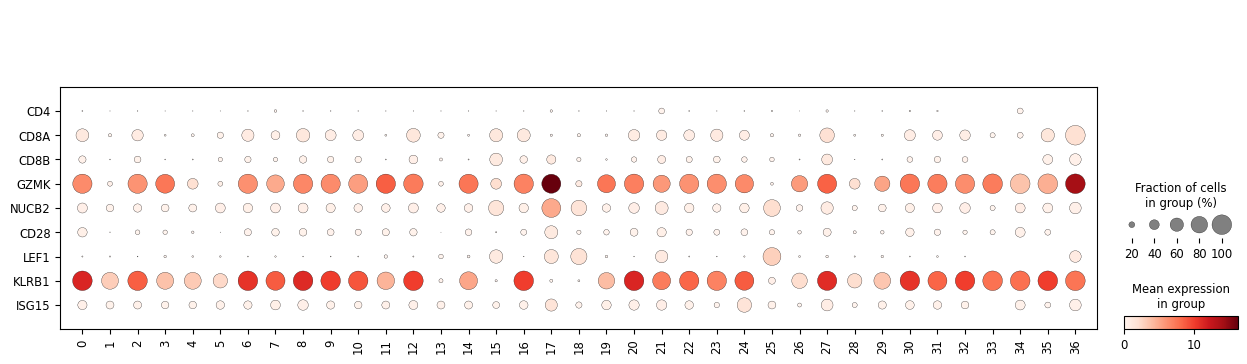

In [33]:
sc.pl.dotplot(adata, 
              groupby = 'leiden_3', 
              var_names = ['CD4','CD8A','CD8B',
                           'GZMK','NUCB2','CD28',
                           'LEF1','KLRB1','ISG15'], 
              swap_axes = True)

In [35]:
adata = propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
)

## Plot refinement

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


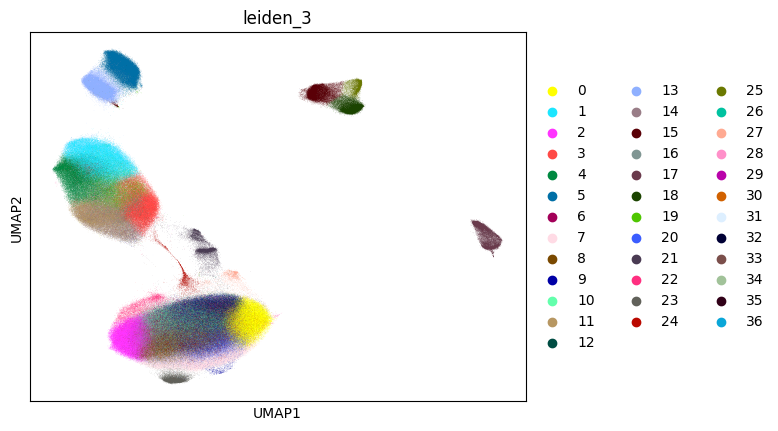

In [36]:
sc.pl.umap(adata, color = 'leiden_3')

**CellTypist Labels**

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


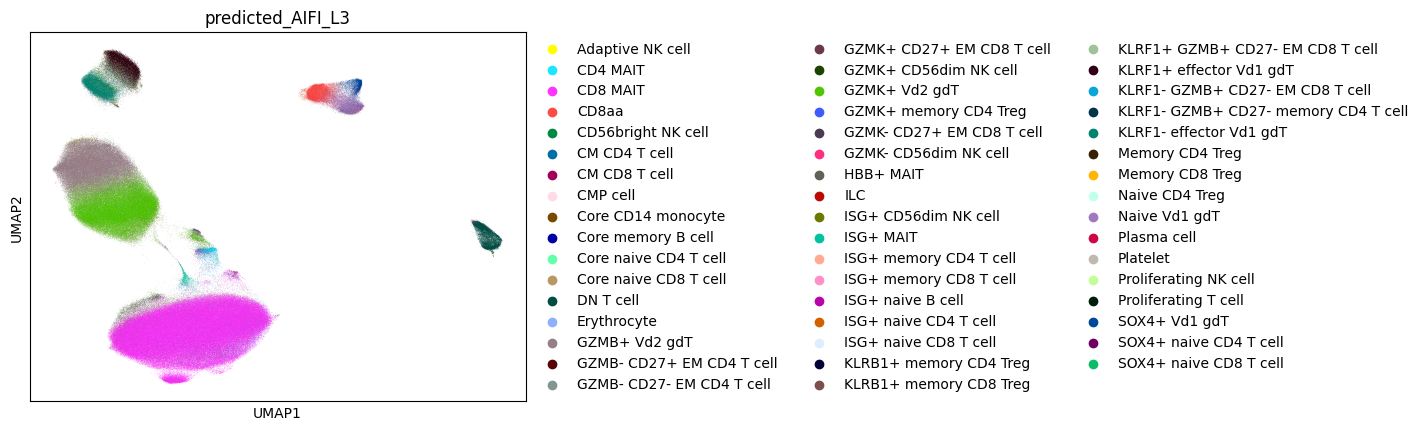

In [37]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3')

**Refined Labels**

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


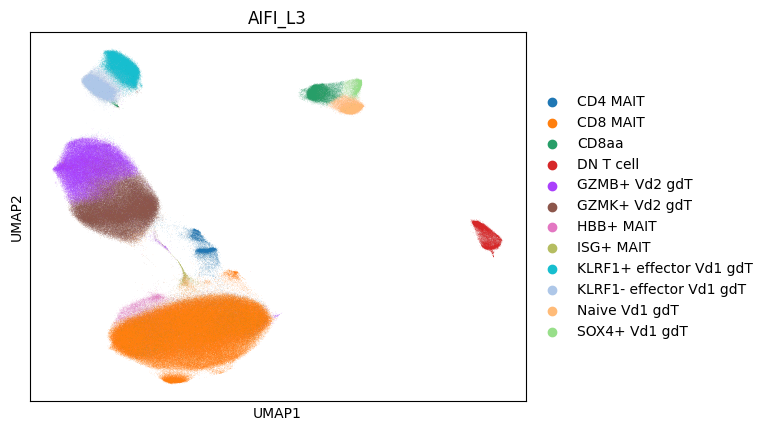

In [38]:
sc.pl.umap(adata, color = 'AIFI_L3')

In [39]:
adata.obs['AIFI_L3'].value_counts()

AIFI_L3
CD8 MAIT                   354003
GZMK+ Vd2 gdT              121677
GZMB+ Vd2 gdT               91151
KLRF1+ effector Vd1 gdT     38458
KLRF1- effector Vd1 gdT     26105
CD8aa                       19514
DN T cell                   16983
Naive Vd1 gdT               15643
CD4 MAIT                    12092
HBB+ MAIT                   10796
SOX4+ Vd1 gdT                5894
ISG+ MAIT                    2695
Name: count, dtype: int64

## Write Outputs to disk

### AnnData object

In [40]:
adata.write_h5ad(out_h5ad)

### Cell metadata and UMAP Coordinates

In [41]:
out_meta = 'output/diha_{c}_AIFI_L3_review_meta_{d}.csv'.format(
    c = class_name,
    d = date.today()
)

In [42]:
obs = obs_with_umap(adata)
obs.to_csv(out_meta)

### Marker gene expression summaries

In [43]:
l2_markers = [
    'CD3E', 'CD4', 'CD8A', 'TRAC', 'TRDC', 
    'LEF1', 'TCF7', 'CCR7', 'SELL', 'ITGB1', 
    'FAS', 'CD27', 'CD28', 'FOXP3', 'RTKN2', 
    'IKZF2', 'ZNF683', 'NKG7', 'KLRC2', 'KLRF1', 
    'KLRB1', 'KLRD1', 'GZMA', 'GZMK', 'GZMB', 
    'PRF1', 'GNLY', 'IFI44L', 'IRF7', 'MKI67', 
    'TRDV1', 'TRDV2', 'TRDV3', 'MME', 'SOX4'
]

In [44]:
out_l2_markers = 'output/diha_{c}_AIFI_L2_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l2_marker_df = tidy_marker_df(
    adata,
    l2_markers,
    'AIFI_L2'
)
l2_marker_df.to_csv(out_l2_markers)

In [45]:
l3_markers = [
    'CD27', 'CD28', 'KLRF1', 'KLRB1', 'KLRD1', 
    'KLRC1', 'KLRC2', 'GZMA', 'GZMB', 'GZMK', 
    'GZMH', 'PRF1', 'CCL5', 'GNLY', 'GATA3', 
    'TBX21', 'EOMES', 'LEF1', 'TCF7', 'IKZF2',
    'TRAC', 'TRDC',
    'TRDV1', 'TRDV2', 'TRDV3',
    'SOX4', 'IFI44L'
]

In [46]:
out_l3_markers = 'output/diha_{c}_AIFI_L3_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l3_marker_df = tidy_marker_df(
    adata,
    l3_markers,
    'AIFI_L3'
)
l3_marker_df.to_csv(out_l3_markers)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [47]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CD8aa dnT gdT MAIT L3 Label Refinement {d}'.format(d = date.today())

In [48]:
search_id = element_id()
search_id

'scandium-silicon-rhenium'

In [49]:
in_files = list(h5ad_uuids.values())
in_files

['da603bcc-e5f3-4ede-889f-e055b60d054d',
 '7c528158-b0c3-473a-9256-54bdaf510d66',
 'ec9f2e39-a65c-4e1a-b7e8-80b818d06166',
 '35912dbb-1911-45fb-8c20-5e3794b3961b']

In [50]:
out_files = [out_h5ad, out_meta, out_l2_markers, out_l3_markers]

In [51]:
out_files

['output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_2024-04-12.h5ad',
 'output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_meta_2024-04-12.csv',
 'output/diha_cd8aa_dnt_gdt_mait_AIFI_L2_review_markers_2024-04-12.csv',
 'output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_markers_2024-04-12.csv']

In [52]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_2024-04-12.h5ad
output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_meta_2024-04-12.csv
output/diha_cd8aa_dnt_gdt_mait_AIFI_L2_review_markers_2024-04-12.csv
output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_markers_2024-04-12.csv
you are trying to upload file_ids... ['output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_2024-04-12.h5ad', 'output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_meta_2024-04-12.csv', 'output/diha_cd8aa_dnt_gdt_mait_AIFI_L2_review_markers_2024-04-12.csv', 'output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_markers_2024-04-12.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': '37edf04e-27a8-402c-a097-91895e17dc4d',
 'files': ['output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_2024-04-12.h5ad',
  'output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_meta_2024-04-12.csv',
  'output/diha_cd8aa_dnt_gdt_mait_AIFI_L2_review_markers_2024-04-12.csv',
  'output/diha_cd8aa_dnt_gdt_mait_AIFI_L3_review_markers_2024-04-12.csv']}

In [53]:
import session_info
session_info.show()